## MDP Class


In [32]:
import numpy as np
from numpy.linalg import inv

class MDP:
    
    '''Constructor for the MDP class

    Inputs:
    T -- Transition function: |A| x |S| x |S'| array
    R -- Reward function: |A| x |S| array
    discount -- discount factor: scalar in [0,1)

    The constructor verifies that the inputs are valid and sets
    corresponding variables in a MDP object'''
    def __init__(self,T,R,discount):
        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (self.nActions,self.nStates,self.nStates), "Invalid transition function: it has dimensionality " + repr(T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (abs(T.sum(2)-1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions" 
        assert R.shape == (self.nActions,self.nStates), "Invalid reward function: it has dimensionality " + repr(R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount


In [74]:
class RL:
    
    '''Constructor for the RL class

    Inputs:
    mdp -- Markov decision process (T, R, discount)
    sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
    This function takes one argument: the mean of the distributon and 
    returns a sample from the distribution.
    '''
    def __init__(self,mdp,sampleReward):
        

        self.mdp = mdp
        self.sampleReward = sampleReward

    '''Procedure to sample a reward and the next state
    reward ~ Pr(r)
    nextState ~ Pr(s'|s,a)

    Inputs:
    state -- current state
    action -- action to be executed

    Outputs: 
    reward -- sampled reward
    nextState -- sampled next state
    '''
    def sampleRewardAndNextState(self,state,action):
    
        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:])
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    '''qLearning algorithm.  
    perform epsilon exploration (i.e., with probability epsilon, select action at random )

    Inputs:
    s0 -- initial state
    initialQ -- initial Q function (|A|x|S| array)
    nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
    nSteps -- # of steps per episode
    epsilon -- probability with which an action is chosen at random
    temperature -- parameter that regulates Boltzmann exploration

    Outputs: 
    Q -- final Q function (|A|x|S| array)
    policy -- final policy
    cumulative_discounted_rewards -- array of size nEpisodes indicating the cumulative discounted rewards for each episode
    '''
    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0):
        Q = initialQ # np.zeros([self.mdp.nActions,self.mdp.nStates])
        policy = np.zeros(self.mdp.nStates,int)
        cumulative_discounted_rewards = np.zeros(nEpisodes)
        # init policy
        for state in range(self.mdp.nStates):
            policy[state] = np.argmax(Q[:, state])
        # init counts
        n_visits = np.zeros([self.mdp.nActions, self.mdp.nStates])
        

        for episode in range(nEpisodes):
            last_state = s0 # init to s0 at the beginning of every episode
            for step in range(nSteps):
                # select and execute action (using policy)
                if np.random.rand() < epsilon:
                    action = np.random.randint(self.mdp.nActions)
                else: action = policy[last_state]

                # observe s' and r
                reward, nextState = self.sampleRewardAndNextState(last_state, action)

                # update cumulated discounted reward
                cumulative_discounted_rewards[episode] = cumulative_discounted_rewards[episode] + reward * self.mdp.discount ** step

                # update counts
                n_visits[action, last_state] = n_visits[action, last_state] + 1

                # calc. learning rate
                lr = 1 / n_visits[action, last_state]

                # find max(Q(s', a'))
                predNextAction = policy[nextState]
                predFutureRewards = Q[predNextAction, nextState]

                # update Q
                Q[action, last_state] = Q[action, last_state] + lr * (reward + self.mdp.discount * predFutureRewards - Q[action, last_state])

                # update policy
                for state in range(self.mdp.nStates):
                    policy[state] = np.argmax(Q[:, state])

                # keep track of current (new) state
                last_state = nextState

        return [Q,policy,cumulative_discounted_rewards]   

    '''modelBasedRLwithValueIteration algorithm.  
    perform epsilon exploration (i.e., with probability epsilon, select action at random )

    Inputs:
    s0 -- initial state
    initialV -- initial value function (array of size |S|)
    nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
    nSteps -- # of steps per episode
    epsilon -- probability with which an action is chosen at random

    Outputs: 
    V -- final value function (array of size |S|)
    policy -- final policy
    '''
    def modelBasedRLwithValueIteration(self,s0,initialV,nEpisodes,nSteps,epsilon=0.1):
        cumulative_discounted_rewards = np.zeros(nEpisodes)
        # init rewards
        rewards = np.zeros([self.mdp.nActions, self.mdp.nStates])
        # init counts
        a_s_sp_counts = np.ones([self.mdp.nActions, self.mdp.nStates, self.mdp.nStates])
        a_s_counts = np.full([self.mdp.nActions, self.mdp.nStates], self.mdp.nStates)
        # init transition
        transitions = a_s_sp_counts / a_s_counts[:, :, np.newaxis]
        # print(transitions)

        # init values related to valueIteration
        V = initialV
        tolerance = 0.01
        nIterations = 10000
        for i in range(nIterations): # limit on # of iterations
            max_reward = None
            for action in range(self.mdp.nActions):

                reward = rewards[action] + self.mdp.discount * (transitions[action] @ V)
                if max_reward is None: max_reward = reward
                max_reward = np.maximum(max_reward, reward)
            last_V = V
            V = max_reward
            # print(V)
            epsilon =  np.max(np.abs(V - last_V))
            if (epsilon < tolerance): break

        # init values related to extractPolicy
        policy = np.array([0]*self.mdp.nStates)
        max_reward = None
        for action in range(self.mdp.nActions):
            reward = rewards[action] + self.mdp.discount * (transitions[action] @ V)
            if max_reward is None: max_reward = reward
            for state in range(self.mdp.nStates):
                if reward[state] > max_reward[state]:
                    policy[state] = action
                    max_reward[state] = reward[state]


        for episode in range(nEpisodes):
            last_state = s0
            for step in range(nSteps):
                # select and execture action (using policy)
                if np.random.rand() < epsilon:
                    action = np.random.randint(self.mdp.nActions)
                else: action = policy[last_state]

                # observe s' and r
                reward, nextState = self.sampleRewardAndNextState(last_state, action)

                # update counts
                a_s_sp_counts[action, last_state, nextState] = a_s_sp_counts[action, last_state, nextState] + 1
                a_s_counts[action, last_state] = a_s_counts[action, last_state] + 1

                # update transition
                transitions = a_s_sp_counts / a_s_counts[:, :, np.newaxis]

                # update reward
                rewards[action, last_state] = (reward + (a_s_counts[action, last_state] - 1)*(rewards[action, last_state])) / a_s_counts[action, last_state]

                # update cumulated discounted reward
                cumulative_discounted_rewards[episode] = cumulative_discounted_rewards[episode] + reward * self.mdp.discount ** step

                # solve for V
                for i in range(nIterations): # limit on # of iterations
                    max_reward = None
                    for action in range(self.mdp.nActions):
                        reward = rewards[action] + self.mdp.discount * (transitions[action] @ V)
                        if max_reward is None: max_reward = reward
                        max_reward = np.maximum(max_reward, reward)
                    last_V = V
                    V = max_reward
                    # print(V)
                    epsilon =  np.max(np.abs(V - last_V))
                    if (epsilon < tolerance): 
                        break

                # update policy
                max_reward = None
                for action in range(self.mdp.nActions):
                    reward = rewards[action] + self.mdp.discount * (transitions[action] @ V)
                    if max_reward is None: max_reward = reward
                    for state in range(self.mdp.nStates):
                        if reward[state] > max_reward[state]:
                            policy[state] = action
                            max_reward[state] = reward[state]

                # keep track of current (new) state
                last_state = nextState


        return [V,policy,cumulative_discounted_rewards]   

In [75]:
# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.7;  # intended move
b = 0.15;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,16] = 1;

T[0,15,11] = a;
T[0,15,14] = b;
T[0,15,15] = b;

T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,16] = 1;

T[1,15,14] = b;
T[1,15,15] = a+b;

T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,16] = 1;

T[2,15,11] = b;
T[2,15,14] = a;
T[2,15,15] = b;

T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,16] = 1;

T[3,15,11] = b;
T[3,15,15] = a+b;

T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,14] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
mdp = MDP(T,R,discount)

# RL problem
rlProblem = RL(mdp,np.random.normal)



epsilon: 0.1


100%|██████████| 10/10 [00:03<00:00,  2.58it/s]


epsilon: 0.3


100%|██████████| 10/10 [00:04<00:00,  2.49it/s]


epsilon: 0.5


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


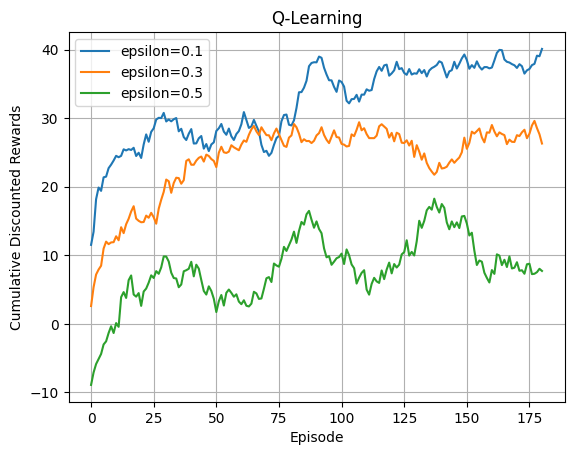

In [35]:
import matplotlib.pyplot as plt
from tqdm import tqdm
trials = 10
epsilons = [.1, .3, .5]
handles_rewards = []
for epsilon in epsilons:
    all_discounted_rewards = []
    print('epsilon: '+ str(epsilon))
    for trial in tqdm(range(trials)):
        [Q,policy,discounted_rewards] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=epsilon)
        all_discounted_rewards.append(discounted_rewards)
    all_discounted_rewards = np.stack(all_discounted_rewards, axis=0)
    all_discounted_rewards = np.mean(all_discounted_rewards, axis=0)
    # Plot the running mean of 20
    running_mean = np.convolve(all_discounted_rewards, np.ones(20)/20, mode='valid')

    handle_rewards, = plt.plot(np.arange(len(running_mean)), running_mean, label='epsilon='+str(epsilon))
    handles_rewards.append(handle_rewards)

plt.grid()
plt.title('Q-Learning')
plt.legend(handles=handles_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Discounted Rewards')
plt.show()



**Explain the impact of the 
exploration probability epsilon on the cumulative discounted rewards per
episode earned during training as well as the resulting Q-values and policy**.

To answer the question, it appears that the higher the value of epsilon, the lower the cumulated discounted rewards per episode and in general. This implies that the model is well-explored already by a lower epsilon. In addition, we see that a higher epsilon leads to a more stable 'cdr' as our Q-values converge, due to the lower probability of taking non-optimal actions. However, at the beginning, a higher epsilon seems to 'learn faster' likely due to more aggressive exploration.

In terms of epsilon's affect on the resulting Q-values and policy, we can see that having a high epsilon results in more Q-values being explored as the agent learns the environment. In contrast, using a low epsilon results in what are likely less-accurate Q-values for non-optimal actions. Related to policy, a high epsilon results in more comprehensive policy (i.e. ability to choose best action regardless of start state) but in the long run suffers from learning slower compared to lower epsilons.

epsilon: 0.1


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


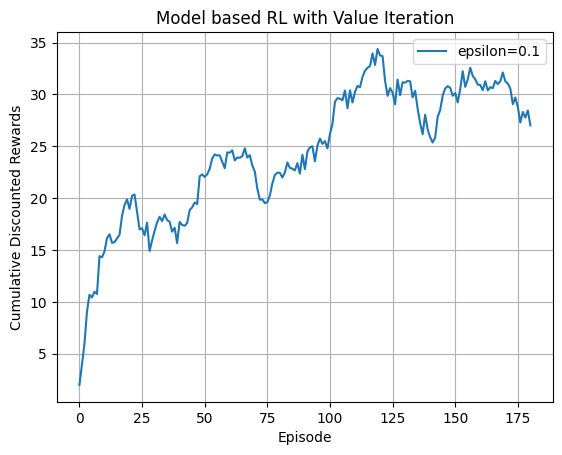

In [76]:
# RL problem
rlProblem = RL(mdp,np.random.normal)

import matplotlib.pyplot as plt
from tqdm import tqdm
trials = 10
epsilon = 0.1
handles_rewards = []
all_discounted_rewards = []
print('epsilon: '+ str(epsilon))
for trial in tqdm(range(trials)):
    [Q,policy,discounted_rewards] = rlProblem.modelBasedRLwithValueIteration(s0=0,initialV=np.zeros([mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=epsilon)
    all_discounted_rewards.append(discounted_rewards)
all_discounted_rewards = np.stack(all_discounted_rewards, axis=0)
all_discounted_rewards = np.mean(all_discounted_rewards, axis=0)
# Plot the running mean of 20 episodes
running_mean = np.convolve(all_discounted_rewards, np.ones(20)/20, mode='valid')

handle_rewards, = plt.plot(np.arange(len(running_mean)), running_mean, label='epsilon='+str(epsilon))
handles_rewards.append(handle_rewards)

plt.grid()
plt.title('Model based RL with Value Iteration')
plt.legend(handles=handles_rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Discounted Rewards')
plt.show()


**How does model-based RL with 
value iteration compare with Q-learning in terms of data efficiency?  Explain.**

In terms of data efficency, model-based RL (w. value iteration) seems to be more data efficent than Q-learning. We can observb this by noting that it reaches a reasonable cdr in fewer episodes than Q-learning. This is possibly due to it being model-based over model-free, where we learn an explicit model faster than trying to solve using many samples (i.e. Q-learning).